In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Load the Data

In [3]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Visualize the Data

In [4]:
### Example Data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
### 1000 examples 1 color, 28 by 28
### 1000 target lables that corresponds to an example
print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

Index: 0
Example Shape: torch.Size([100, 1, 28, 28])
Target Shape : torch.Size([100])


<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

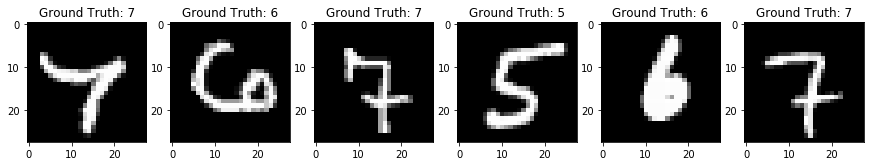

In [6]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

### Multilayer Perceptron

In [7]:
### x.view(-1, 28*28) -1 mean reshape tensor with appropriate rows given 28*28 columns
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

### Training

In [8]:
model = MLPNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [9]:
### Create the Training Loop
for epoch in range(n_epochs):
    #training
    avg_loss = 0
    
    #loop through the training data
    for batch_idx, (x, label) in enumerate(train_loader):
        optimizer.zero_grad()                              #zero out the gradient for each minibatch
        x, label = Variable(x), Variable(label)
        output = model(x)                                  #get the output of the model fed forward
        loss = loss_function(output, label)                #calculate the loss of the output
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1      #update the avg loss using momentum beta=.9
        loss.backward()                                    #back propagate
        optimizer.step()                                   #update the optimizer
        
        #print the current stats
        if (batch_idx+1) % 200 == 0 or (batch_idx+1) == len(train_loader):
            print ('**** epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx+1, avg_loss))


    #loop through the testing data for validation
    correct_pred = 0
    total_count = 0
    with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
            x, label = Variable(x), Variable(label) 
            output = model(x)
            loss = loss_function(output, label)
            _, pred_label = torch.max(output.data, 1)                  #return max of prediction array

            total_count += x.data.size()[0]                            #update total count with batch size
            correct_pred += (pred_label == label.data).sum().item()    #update correct predictions using sum of correct preds

            avg_loss = avg_loss * 0.9 + loss.item() * 0.1              #update loss

            if(batch_idx+1) % 1000 == 0 or (batch_idx+1) == len(test_loader):
                print ('@@@@ epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx+1, avg_loss, correct_pred * 1.0 / total_count))
            
#### Save the final model
torch.save(model.state_dict(), model.name())

    

**** epoch: 0, batch index: 200, train loss: 0.299103
**** epoch: 0, batch index: 400, train loss: 0.195498
**** epoch: 0, batch index: 600, train loss: 0.200295
**** epoch: 0, batch index: 800, train loss: 0.142896
**** epoch: 0, batch index: 938, train loss: 0.151294
@@@@ epoch: 0, batch index: 100, test loss: 0.141187, acc: 0.958
**** epoch: 1, batch index: 200, train loss: 0.131875
**** epoch: 1, batch index: 400, train loss: 0.113481
**** epoch: 1, batch index: 600, train loss: 0.098396
**** epoch: 1, batch index: 800, train loss: 0.095889
**** epoch: 1, batch index: 938, train loss: 0.118362
@@@@ epoch: 1, batch index: 100, test loss: 0.059145, acc: 0.975
**** epoch: 2, batch index: 200, train loss: 0.054072
**** epoch: 2, batch index: 400, train loss: 0.065374
**** epoch: 2, batch index: 600, train loss: 0.060321
**** epoch: 2, batch index: 800, train loss: 0.082199
**** epoch: 2, batch index: 938, train loss: 0.063460
@@@@ epoch: 2, batch index: 100, test loss: 0.055848, acc: 0

In [16]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

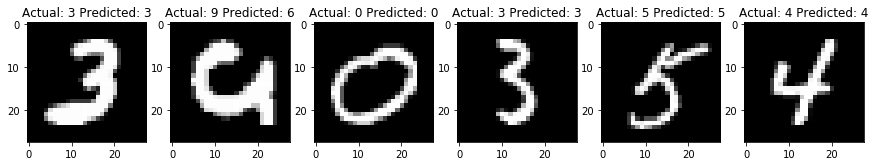

In [17]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt

In [18]:
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

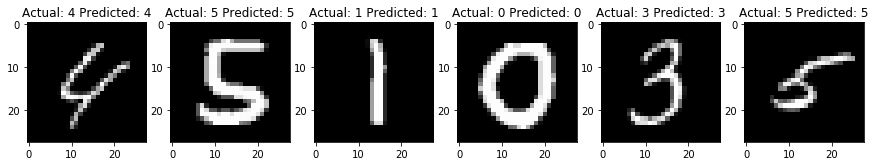

In [19]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt